In [1]:
import numpy as np
import pandas as pd
import torch
from typing import Optional, Literal, Union
import matplotlib.pyplot as plt

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

## Test ordinary lr in torch

Data generating model and data:

In [2]:
# tt = torch.tensor([[1.1, ], [0.2, ], [0.3, ], [-0.4, ]])
# print(rank(tt))
# print(normalize_rank(rank(tt)))

In [3]:
# soft_rank(tt.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)

In [4]:
def generate_data(n_features: int, n_samples: int, noise: float = 0.0) -> tuple[object, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate data."""
    torch.manual_seed(0)

    # the true data generating model
    model_true = torch.nn.Linear(n_features, 1)

    # For the simplicity of the analysis, set the model params
    # to the numbers running from 1 through (n_features + 1).
    with torch.no_grad():
        i = 1
        for name, param in model_true.named_parameters():
            param.copy_(torch.arange(i, i + param.numel()))
            i += param.numel()
            param.requires_grad = False

    # Generate training and test data.
    X_train = torch.rand((n_samples, n_features))
    y_train = model_true(X_train) + noise * torch.randn(size=(X_train.size()[0], 1))

    X_test = torch.rand((n_samples // 10, n_features))
    y_test = model_true(X_test) + noise * torch.randn(size=(X_test.size()[0], 1))

    return model_true, X_train, y_train, X_test, y_test

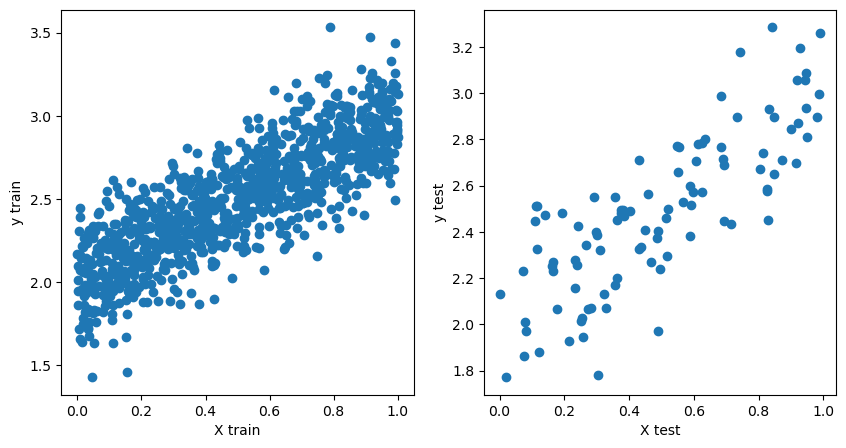

In [5]:
n_features = 1
n_samples = 1000
noise = 0.2

model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(X_train.detach().numpy(), y_train.numpy())
axs[0].set_xlabel("X train")
axs[0].set_ylabel("y train")

axs[1].scatter(X_test.detach().numpy(), y_test.numpy())
axs[1].set_xlabel("X test")
axs[1].set_ylabel("y test")

plt.show()

In [6]:
for name, param in model_true.named_parameters():
    print(name, param)

weight Parameter containing:
tensor([[1.]])
bias Parameter containing:
tensor([2.])


Help funcs:

In [7]:
def init_model(n_features: int, lr: float, weight_decay: float) -> tuple[object, object]:
    """Initialize model.
        Params:
            n_features: number of features the model will have
            lr: learning rate
            weight_decay: L2 regularization strength
        Return:
            initialized model and optimizer
    """
    torch.manual_seed(2023)
    model = torch.nn.Linear(n_features, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    return model, optimizer

def train_step(X: torch.Tensor, y: torch.Tensor, model: object, loss_fn: object, optimizer: object) -> torch.Tensor:
    """Make one training step."""
    # Compute prediction and loss
    y_hat = model(X)
    loss = loss_fn(y, y_hat)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # did not forget!

    return loss

def train(
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        n_features: int,
        n_steps: int,
        lr: float,
        weight_decay: float,
        loss_fn: object,
        eval_fns: dict[str, object]
        ) -> tuple[object, pd.DataFrame]:
    """Train LR model."""
    model, optimizer = init_model(n_features, lr=lr, weight_decay=weight_decay)

    print("Initial model params:")
    for name, param in model.named_parameters():
        print(f"{name}:\t{param}")
    print()

    # init 'stats' dict that will store training and eval stats
    stats = {"training loss": [], "test loss": []}
    for eval_name in eval_fns.keys():
        stats[f"training {eval_name}"] = []
        stats[f"test {eval_name}"] = []
    
    # make training steps
    for _ in range(n_steps):
        train_loss = train_step(X_train, y_train, model, loss_fn, optimizer)
        test_loss = loss_fn(y_test, model(X_test))
        stats["training loss"].append(train_loss.item())
        stats["test loss"].append(test_loss.item())
        for eval_name, eval_fn in eval_fns.items():
            train_eval = eval_fn(y_train, model(X_train))
            test_eval = eval_fn(y_test, model(X_test))
            stats[f"training {eval_name}"].append(train_eval.item())
            stats[f"test {eval_name}"].append(test_eval.item())

    print("Final model params:")
    for name, param in model.named_parameters():
        print(f"{name}:\t{param}")
    
    return model, pd.DataFrame(stats)

def rank(y: torch.Tensor) -> torch.Tensor:
    "Rank real numbers."
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
    return r

def normalize_rank(r: torch.Tensor) -> torch.Tensor:
    """Normalize ranks to [0, 1]."""
    r_norm = (r - 1) / (r.max() - 1)
    return r_norm

############################### Loss funcs ###############################
def loss_mse(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """MSE loss."""
    criterion = torch.nn.MSELoss()
    return criterion(y, y_hat)

def loss_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    "Mean squared soft rank difference loss."
    # rank true values
    r = rank(y)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    loss = criterion(r, r_hat)

    return loss

def loss_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """soft Spearman corr loss."""
    # rank true values
    r = rank(y)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # Spearman corr
    loss = 1 - torch.corrcoef(torch.cat((r.reshape(1, -1), r_hat.reshape(1, -1)), dim=0))[0, 1]

    return loss

############################### Metrics ###############################
def eval_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """Mean squared exact rank difference metric."""
    # exact ranks
    r = rank(y)
    r_hat = rank(y_hat)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    eval = criterion(r, r_hat)

    return eval

def eval_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """(exact) Spearman corr metric"""
    y = y.reshape(1, -1).squeeze().numpy()
    y_hat = y_hat.reshape(1, -1).squeeze().detach().numpy()
    eval = pd.DataFrame({"y": y, "y_hat": y_hat}).corr("spearman").iloc[0, 1]
    return torch.tensor(eval)

## Objective: MSE, eval: MSE

In [27]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise=0)

# check that model params have been set correctly
print("True model params:")
for name, param in model_true.named_parameters():
    print(name, param)
print()

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-2,
        weight_decay=0.0,
        loss_fn=loss_mse,
        eval_fns={"MSE": loss_mse, "MSRD": eval_msrd, "Spearman": eval_spearman}
        )

True model params:
weight Parameter containing:
tensor([[1.]])
bias Parameter containing:
tensor([2.])

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)

Final model params:
weight:	Parameter containing:
tensor([[0.9959]], requires_grad=True)
bias:	Parameter containing:
tensor([2.0022], requires_grad=True)


Learning curves:

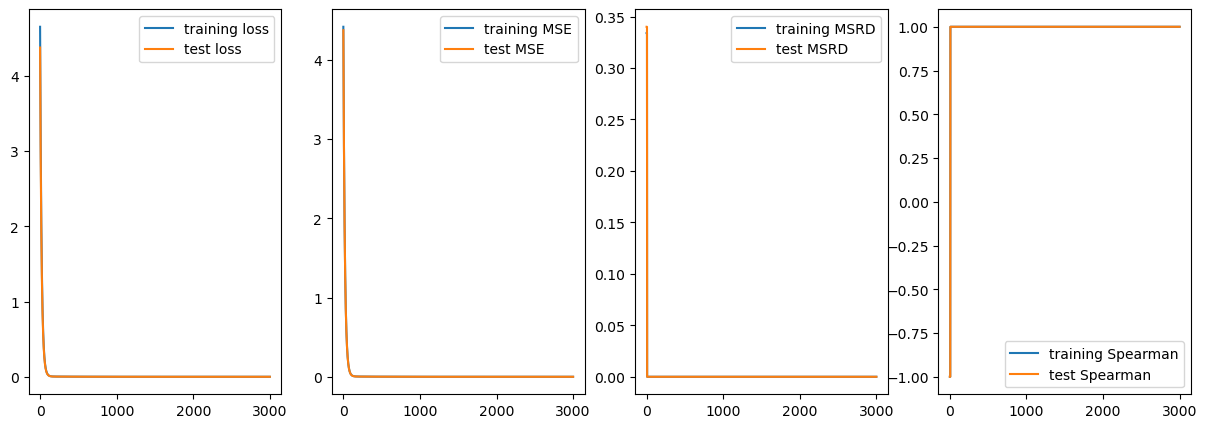

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Spearman corr by eyes:

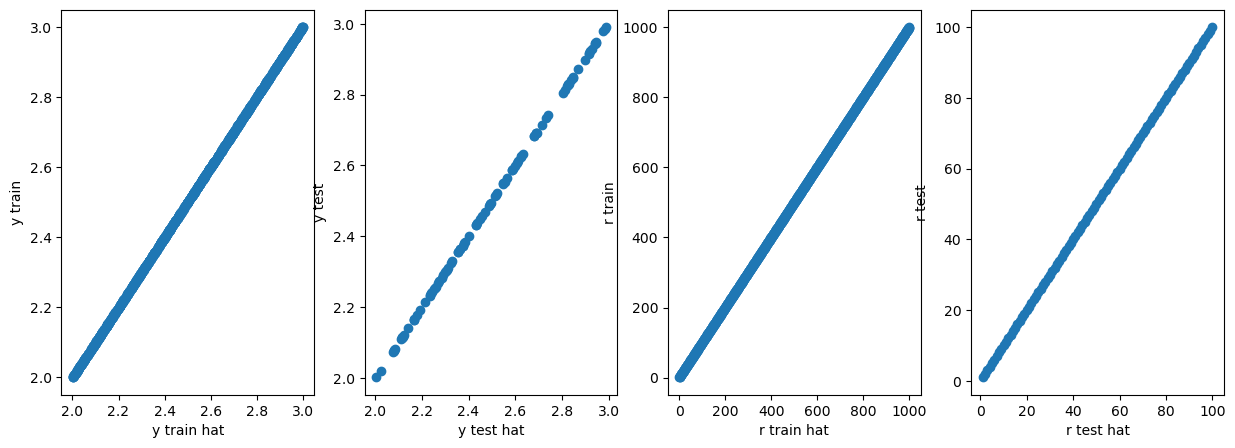

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()

In [30]:
stats

,training loss,test loss,training MSE,test MSE,training MSRD,test MSRD,training Spearman,test Spearman
0,4.653524,4.377463,4.420655,4.377463,0.334001,0.340067,-1.0,-1.0
1,4.420655,4.158154,4.199449,4.158154,0.334001,0.340067,-1.0,-1.0
2,4.199449,3.949836,3.989324,3.949836,0.334001,0.340067,-1.0,-1.0
3,3.989324,3.751958,3.789723,3.751958,0.334001,0.340067,-1.0,-1.0
4,3.789723,3.563998,3.600120,3.563998,0.334001,0.340067,-1.0,-1.0
...,...,...,...,...,...,...,...,...
2995,0.000001,0.000001,0.000001,0.000001,0.000000,0.000000,1.0,1.0
2996,0.000001,0.000001,0.000001,0.000001,0.000000,0.000000,1.0,1.0
2997,0.000001,0.000001,0.000001,0.000001,0.000000,0.000000,1.0,1.0
2998,0.000001,0.000001,0.000001,0.000001,0.000000,0.000000,1.0,1.0


## Objective: MSRD, eval: exact MSRD

In [13]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-3,
        weight_decay=0.3,
        loss_fn=loss_msrd,
        eval_fns={"MSE": loss_mse, "MSRD": eval_msrd, "Spearman": eval_spearman}
        )

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)

Final model params:
weight:	Parameter containing:
tensor([[-0.2744]], requires_grad=True)
bias:	Parameter containing:
tensor([0.1789], requires_grad=True)


Learning curves:

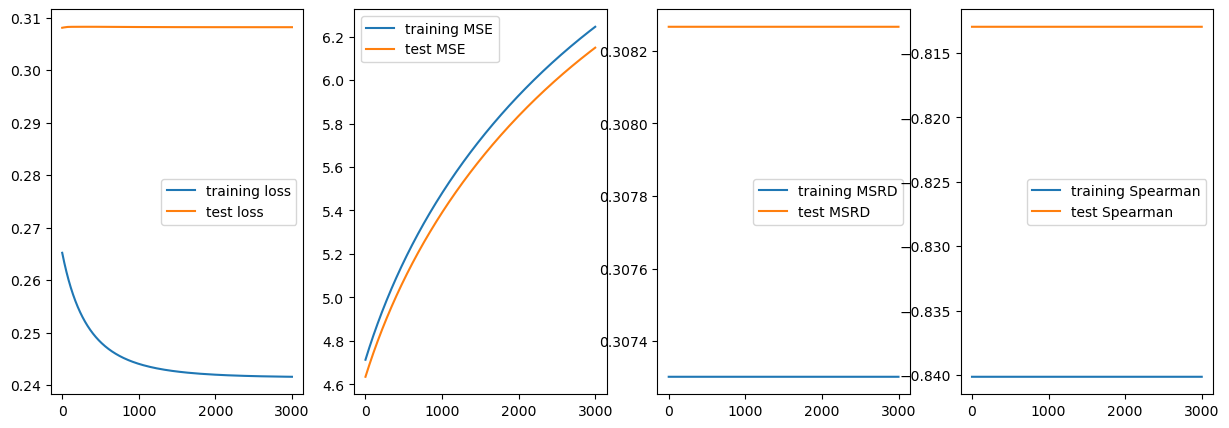

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Spearman corr by eyes:

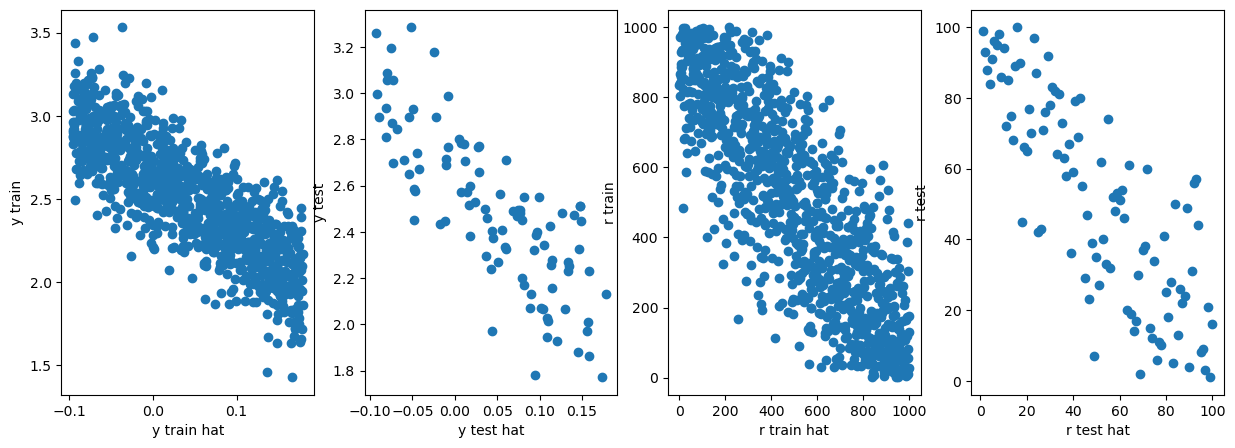

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()

Learned model params:

In [16]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[-0.2744]], requires_grad=True)
bias:	Parameter containing:
tensor([0.1789], requires_grad=True)


## Objective: Spearman

In [17]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=1000,
        lr=2e-3,
        weight_decay=0.0,
        loss_fn=loss_spearman,
        eval_fns={"MSE": loss_mse, "MSRD": eval_msrd, "Spearman": eval_spearman}
        )

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)

Final model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)


Learning curves:

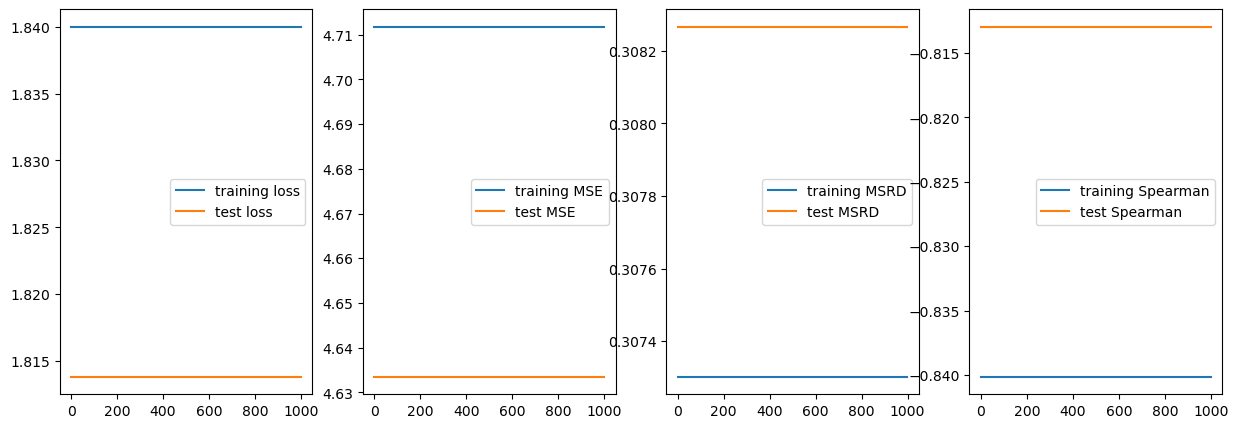

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Spearman corr by eyes:

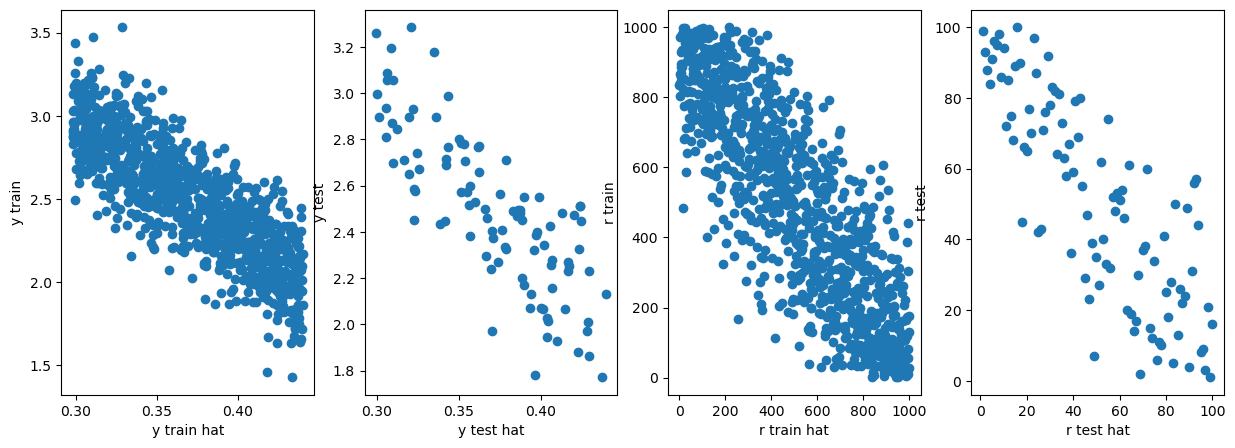

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()

Learned model params:

In [20]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)
